<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/Soma_Size/Cell_pose_JB_data_PF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-image --quiet
!pip install matplotlib --quiet
!pip install pandas --quiet
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet
!pip install cellpose --quiet

ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [2]:
import matplotlib
import tifffile
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import pandas as pd
from tqdm import tqdm
import scipy as sci
from cellpose import models

In [3]:
def plot_point_data_pcol(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),rad=None,cmap='viridis'):
    """ Assume 'zxyc' format"""

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[1]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[2]])
        image_stack = image_stack[:,min_y:max_y,min_x:max_x]
        x=rad
        y=rad

    xy_slice = image_stack[z,:,:]
    zy_slice = image_stack[:,:,x].transpose([1,0])
    zx_slice = image_stack[:,y,:]

    vmin = np.percentile(image_stack,.1)
    vmax = np.percentile(image_stack,99.9)
    print(vmin,vmax)

    fig,ax=plt.subplots(2,3,width_ratios=[5, 1, .5],height_ratios=(5,1),figsize=figsize,dpi=300)
    ax=ax.flatten()
    # ,aspect='auto'
    cbh=ax[0].pcolorfast(xy_slice,zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # cmap=cmap,
    ax[0].axvline(x,color='m',linewidth=lw)
    ax[0].axhline(y,color='c',linewidth=lw)
    ax[0].set_xticks([])
    ax[0].invert_yaxis()

    ax[1].imshow(zy_slice,aspect='auto',zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[1].axhline(y,color='c',linewidth=lw)
    ax[1].axvline(z,color='y',linewidth=lw)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    ax[3].imshow(zx_slice,aspect='auto',zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[3].axvline(x,color='m',linewidth=lw)
    ax[3].axhline(z,color='y',linewidth=lw)

    plt.colorbar(cbh,cax=ax[2])

    for a in ax[4:]:
        a.axis('off')
    plt.tight_layout()
    return fig,ax,cbh

In [4]:
def plot_point_data_rgb(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),rad=None):
    """ Assume 'zxyc' format"""

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[1]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[2]])
        image_stack = image_stack[:,min_y:max_y,min_x:max_x,:]
        x=rad
        y=rad

    print(image_stack.shape,x,y)

    xy_slice = image_stack[z,:,:,:]
    zy_slice = image_stack[:,:,x,:].transpose([1,0,2])
    zx_slice = image_stack[:,y,:,:]


    z_ratio = image_stack.shape[0]/image_stack.shape[1]

    fig,ax=plt.subplots(2,2,width_ratios=[1, z_ratio],height_ratios=(1,z_ratio),figsize=figsize,dpi=300)
    ax=ax.flatten()

    ax[0].imshow(xy_slice,aspect='auto',zorder=-1) # vmin=vmin,vmax=vmax,cmap=cmap,
    ax[0].axvline(x,color='m',linewidth=lw)
    ax[0].axhline(y,color='c',linewidth=lw)
    ax[0].set_xticks([])

    ax[1].imshow(zy_slice,aspect='auto',zorder=-1) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[1].axhline(y,color='c',linewidth=lw)
    ax[1].axvline(z,color='y',linewidth=lw)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    ax[2].imshow(zx_slice,aspect='auto',zorder=-1) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[2].axvline(x,color='m',linewidth=lw)
    ax[2].axhline(z,color='y',linewidth=lw)




    ax[3].axis('off')
    plt.tight_layout()
    return fig,ax



def dimension_to_front(data,dim_x):
    dim_list = list(np.arange(len(data.shape)))
    transpose = [dim_list[dim_x]] + dim_list[:dim_x] + dim_list[dim_x+1:]
    data_t = data.transpose(transpose)
    data_t =data_t.astype('float16')
    invs_transpose = list(np.argsort(transpose))
    return data_t, transpose, invs_transpose

def norm_channels(im_data,tiff_format,clip=False):
    color_dim = tiff_format.index('c')
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),[99,1])
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data

def med_filt_stack(img,d):
    tiff_format = 'zcyx'
    color_dim = tiff_format.index('c')
    z_dim = tiff_format.index('z')
    color_dim=1
    z_dim=0
    for c in range(img.shape[color_dim]):
        for z in range(img.shape[z_dim]):
            img[z,c,:,:] = ski.filters.median(img[z,c,:,:],footprint=np.ones([d,d]))
    return img


In [5]:

"""On Site"""
source_directory = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF'
# """Off Site"""
# source_directory = 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF'

os.chdir(source_directory)
my_tiffs = list()
for rt,dirs,file_list in os.walk(source_directory):
    for file in file_list:
        if 'tif' in file:
            my_tiffs.append(os.path.join(rt,file))
curr_tif = my_tiffs[0]
print(curr_tif)

C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\DAPI-NeuN_E3-E_20x2_1.tif


'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\\DAPI-NeuN_E3-E_20x2_1.tif'

In [7]:
""" Propper Funcs """

def trim_edge_bound(masks):
    masks_og = masks.copy()
    planes = [masks[0,:,:],
              masks[-1,:,:],
              masks[:,0,:],
              masks[:,-1,:],
              masks[:,:,0],
              masks[:,:,-1]]

    for p in planes:
        del_ids = np.unique(p)
        for id in del_ids:
            masks[masks==id] = 0
    return masks, masks_og

def fit_cell_model(img_rgb, cell_channel=1, nuclear_channel=0,channel_axis=3):
    cell_diam=40
    cell_model = models.Cellpose(model_type='cyto3',gpu=True)
    (cell_masks, flows, styles, diams) = cell_model.eval(
        img_rgb, channels=[cell_channel,nuclear_channel],
        channel_axis = channel_axis, diameter=cell_diam,
        do_3D=False, stitch_threshold=0.02)

    results_dict = {'cell_masks':cell_masks,
                'flows':flows,
                'styles':styles,
                'diams':diams,
                'cell_model':cell_model,}
    return results_dict

def fit_nuclear_model(img_rgb,nuclear_channel=3,channel_axis=3):
    nuc_diam = None
    nuclear_model = models.Cellpose(model_type='nuclei',gpu=True)
    (nuclear_masks, _, _, _)=  nuclear_model.eval(
        img_rgb, channels=[nuclear_channel, 0],
        channel_axis = channel_axis, diameter=nuc_diam,
        do_3D=False, stitch_threshold=0.02,)
    return nuclear_masks

def tiff_to_RGB_stack(tiff_data,rbg_channel_order = [1,0,0]):
    tiff_data = tiff_data[:,rbg_channel_order,:,:]
    tiff_data[:,1,:,:]=0
    rgb_stack = tiff_data.transpose([0,2,3,1])*225
    rgb_stack[rgb_stack<0]=0
    rgb_stack[rgb_stack>255]=255
    rgb_stack=rgb_stack.astype('uint8')
    return rgb_stack

def preprocess_image(tiff_data):
    tiff_data = ski.filters.gaussian(
        tiff_data, sigma=[1,1,1],
        mode='reflect',truncate = 4,
        channel_axis=1)
    tiff_data = med_filt_stack(tiff_data,5)
    tiff_data = norm_channels(tiff_data,'zcxy',clip=True,pct=[99,1])
    return tiff_data

def split_proj(tiff_data):
    print(tiff_data.shape)
    num_c = tiff_data.shape[3]
    fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
    colors = ['Reds','Greens','Blues','gray']
    for c in range(num_c):
        ax[c].imshow(np.max(tiff_data[:,:,:,c],axis=0), cmap=colors[c],vmin=0,vmax=255)
        ax[c].axis('off')
    plt.tight_layout()


def norm_channels(im_data,tiff_format,clip=False,pct=[99,1]):
    print(im_data.shape)
    color_dim = tiff_format.index('c')
    print('norm color dim =',color_dim)
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),pct)
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data

(29, 2, 800, 800)
norm color dim = 1
(29, 800, 800, 3)


image is not 2D cannot compute diameter
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 208.14it/s]


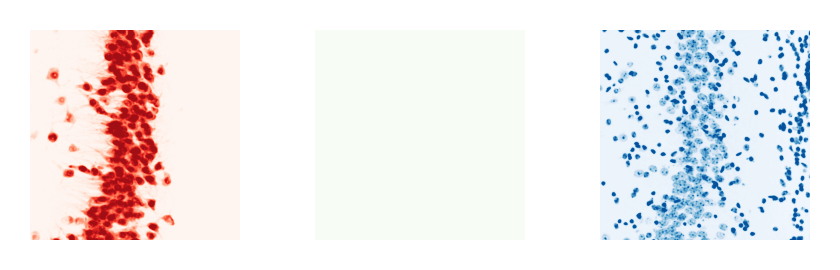

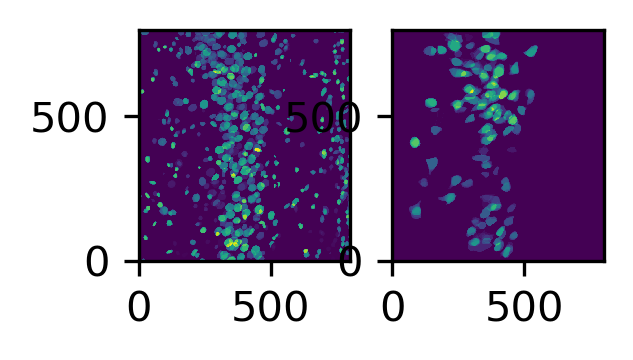

In [13]:
"""MAIN"""

# def qunatify_image_stack(tiff_loc):
tiff_data_raw = tifffile.imread(curr_tif)
tiff_data = preprocess_image(tiff_data_raw)
rgb_stack = tiff_to_RGB_stack(tiff_data)
split_proj(rgb_stack)

nuclear_masks = fit_nuclear_model(rgb_stack,nuclear_channel=3,channel_axis=3)
results_dict = fit_cell_model(rgb_stack,channel_axis=3)
cell_masks = results_dict['cell_masks']
cell_masks, cell_masks_og = trim_edge_bound(cell_masks)

fig,ax = plt.subplots(1,2,figsize=(2,1),dpi=300)
ax[0].pcolorfast(np.sum(nuclear_masks,axis=0))
ax[1].pcolorfast(np.sum(cell_masks,axis=0))
